In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os,sys
import tensorflow as tf
import time
from tensorflow import keras
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'
print(tf.__version__)
print(sys.version_info)
for module in mpl,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.1.1
pandas 0.25.2
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
tf.test.is_gpu_available()

False

In [3]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
train_labels_file = './cifar10/trainLabels.csv'
test_csv_file = './cifar10/sampleSubmission.csv'
train_folder = './cifar10/train'
test_folder = './cifar10/test'

def parse_csv_file(filepath,folder):
    """parsers csv files into(filename(path),label) format"""
    results = []
    with open(filepath,'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id,label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder,image_id + '.png')
        results.append((image_full_path,label_str))
    return results


train_labels_info = parse_csv_file(train_labels_file,train_folder)
test_csv_info = parse_csv_file(test_csv_file,test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info),len(test_csv_info))

[('./cifar10/train\\1.png', 'frog'),
 ('./cifar10/train\\2.png', 'truck'),
 ('./cifar10/train\\3.png', 'truck'),
 ('./cifar10/train\\4.png', 'deer'),
 ('./cifar10/train\\5.png', 'automobile')]
[('./cifar10/test\\1.png', 'cat'),
 ('./cifar10/test\\2.png', 'cat'),
 ('./cifar10/test\\3.png', 'cat'),
 ('./cifar10/test\\4.png', 'cat'),
 ('./cifar10/test\\5.png', 'cat')]
50000 300000


In [4]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

# 修改列名
train_df.columns = ['filepath','class']
valid_df.columns = ['filepath','class']
test_df.columns = ['filepath','class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                filepath       class
0  ./cifar10/train\1.png        frog
1  ./cifar10/train\2.png       truck
2  ./cifar10/train\3.png       truck
3  ./cifar10/train\4.png        deer
4  ./cifar10/train\5.png  automobile
                    filepath       class
0  ./cifar10/train\45001.png       horse
1  ./cifar10/train\45002.png  automobile
2  ./cifar10/train\45003.png        deer
3  ./cifar10/train\45004.png  automobile
4  ./cifar10/train\45005.png    airplane
               filepath class
0  ./cifar10/test\1.png   cat
1  ./cifar10/test\2.png   cat
2  ./cifar10/test\3.png   cat
3  ./cifar10/test\4.png   cat
4  ./cifar10/test\5.png   cat


In [5]:
# 读取图片
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
rescale = 1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(train_df,directory='./',x_col='filepath',y_col='class',classes=class_names,
                                                    target_size=(height,width),batch_size=batch_size,seed=7,shuffle=True,
                                                    class_mode='sparse',)


valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(valid_df,directory='./',x_col='filepath',y_col='class',classes=class_names,
                                                    target_size=(height,width),batch_size=batch_size,seed=7,shuffle=False,
                                                    class_mode="sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num,valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [6]:
# 读取数据
for i in range(2):
    x,y = train_generator.next()
    print(x.shape,y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',input_shape=[width,height,channels]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    # 展平
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(num_classes,activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [8]:
epochs = 20
history = model.fit_generator(train_generator,steps_per_epoch = train_num // batch_size,epochs=epochs,
                            validation_data = valid_generator,va
                              
                              
                              lidation_steps=valid_num // batch_size)

Epoch 1/20
1406/1406 [==============================] - 1858s 1s/step - loss: 3.1899 - accuracy: 0.2409 - val_loss: 1.7016 - val_accuracy: 0.3862
Epoch 2/20
1406/1406 [==============================] - 1775s 1s/step - loss: 1.7539 - accuracy: 0.3540 - val_loss: 2.2529 - val_accuracy: 0.2931
Epoch 3/20
1406/1406 [==============================] - 1779s 1s/step - loss: 1.5893 - accuracy: 0.4226 - val_loss: 1.5816 - val_accuracy: 0.4437
Epoch 4/20
1406/1406 [==============================] - 1771s 1s/step - loss: 1.4560 - accuracy: 0.4726 - val_loss: 1.3168 - val_accuracy: 0.5411
Epoch 5/20
1406/1406 [==============================] - 1773s 1s/step - loss: 1.3325 - accuracy: 0.5219 - val_loss: 1.7964 - val_accuracy: 0.4615
Epoch 6/20
1406/1406 [==============================] - 1770s 1s/step - loss: 1.2058 - accuracy: 0.5723 - val_loss: 1.1314 - val_accuracy: 0.6134
Epoch 7/20
1406/1406 [==============================] - 1774s 1s/step - loss: 1.0877 - accuracy: 0.6168 - val_loss: 0.9419 -

In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


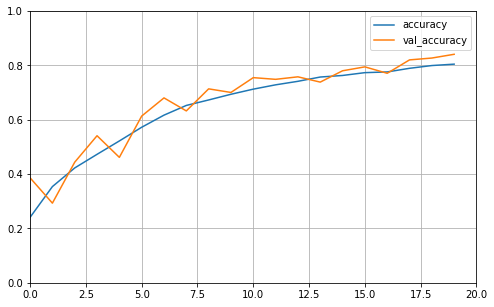

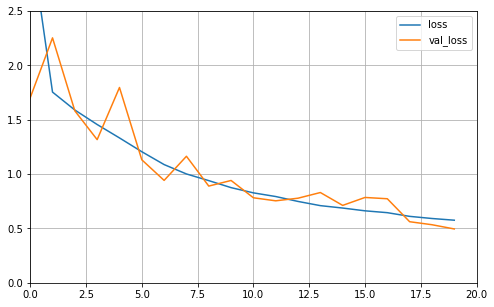

In [11]:
# 学习曲线
def plot_learning_curves(hsitory,label,epochs,min_value,max_value):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = hsitory.history['val_' + label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0,epochs,min_value,max_value])
    plt.show()

plot_learning_curves(history,'accuracy',epochs,0,1)
plot_learning_curves(history,'loss',epochs,0,2.5)

In [12]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,directory='./',x_col='filepath',y_col='class',classes=class_names,
                                                    target_size=(height,width),batch_size=batch_size,seed=7,shuffle=False,
                                                    class_mode="sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [ ]:
test_predict = model.predict_generator(test_generator,workers=10,use_multiprocessing=False)
# True 进程； False:线程

In [ ]:
print(test_predict.shape)

In [ ]:
print(test_predict[0:5])

In [ ]:
test_predict_class_indices = np.argmax(test_predict,axis=1)
print(test_predict_class_indices[0:5])

In [ ]:
test_predict_class=[class_names[index] for index in test_predict_class_indices]
print(test_predict_class[0:5])